In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# **Necessary Imports**

In [15]:

import seaborn as sns


from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
from keras.utils import to_categorical
import keras.layers as layers
from keras.callbacks import EarlyStopping
import tensorflow.keras.layers.experimental.preprocessing as preprocessing


# **Reading Input Data**

In [3]:
train_raw = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_raw = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
train_raw.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **Checking for null values - Train Data**

In [4]:
train_raw.isnull().any().describe()

count       785
unique        1
top       False
freq        785
dtype: object

# **Checking for null values - Test Data**

In [5]:
test_raw.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

# **Plot for Label Count**

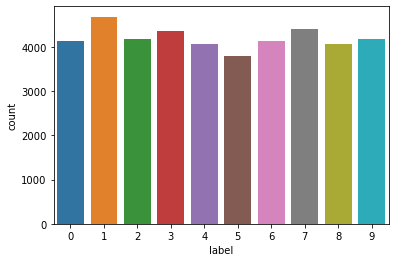

In [6]:
sns.countplot(train_raw['label']);

In [7]:
y = train_raw['label']
X = train_raw.drop(labels=['label'], axis=1)
y.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

# **Normalizing and Reshaping**

In [8]:
#Normalizing the data
X = X / 255.0
test_raw = test_raw / 255.0

#Reshaping the data

X = X.values.reshape(-1, 28, 28, 1)
test_raw = test_raw.values.reshape(-1, 28, 28, 1)

In [9]:
y = to_categorical(y, num_classes=10)

# **Spliting data into Train and Validation data**

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(29400, 28, 28, 1) (29400, 10) (12600, 28, 28, 1) (12600, 10)


# **Designing the model**

In [29]:
model = keras.Sequential([
    
    layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', padding='same',
                  input_shape=(28, 28, 1)),
    
    # Data Augmentation
    
    preprocessing.RandomFlip(mode='horizontal'),
    preprocessing.RandomRotation(factor=0.10),
    
    layers.MaxPool2D(pool_size=(2,2)),
    
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='sigmoid'),
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 28, 28, 64)        1664      
_________________________________________________________________
random_flip_3 (RandomFlip)   (None, 28, 28, 64)        0         
_________________________________________________________________
random_rotation_3 (RandomRot (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 14, 14, 64)        448       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 128)        

# **Model compiling by adding - Optimizer , loss and Accuracy**

In [30]:
model.compile( 
    optimizer=keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

# **Including an early stopping callback to prevent overfitting.**

In [31]:
early_stopping = EarlyStopping(min_delta=0.001, patience=5, restore_best_weights=True)

# **Model Training**

In [32]:
history = model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=50,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping]
)

Epoch 1/50
230/230 [==============================] - 4s 18ms/step - loss: 0.3982 - binary_accuracy: 0.8678 - val_loss: 0.0857 - val_binary_accuracy: 0.9684
Epoch 2/50
230/230 [==============================] - 4s 17ms/step - loss: 0.0968 - binary_accuracy: 0.9656 - val_loss: 0.0377 - val_binary_accuracy: 0.9873
Epoch 3/50
230/230 [==============================] - 4s 17ms/step - loss: 0.0576 - binary_accuracy: 0.9812 - val_loss: 0.0258 - val_binary_accuracy: 0.9916
Epoch 4/50
230/230 [==============================] - 4s 18ms/step - loss: 0.0415 - binary_accuracy: 0.9870 - val_loss: 0.0204 - val_binary_accuracy: 0.9932
Epoch 5/50
230/230 [==============================] - 4s 18ms/step - loss: 0.0324 - binary_accuracy: 0.9897 - val_loss: 0.0160 - val_binary_accuracy: 0.9948
Epoch 6/50
230/230 [==============================] - 4s 17ms/step - loss: 0.0269 - binary_accuracy: 0.9916 - val_loss: 0.0133 - val_binary_accuracy: 0.9956
Epoch 7/50
230/230 [==============================] - 4s 1

# **Plot for analyzing model training **

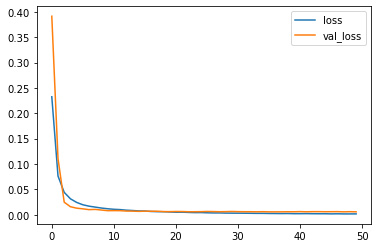

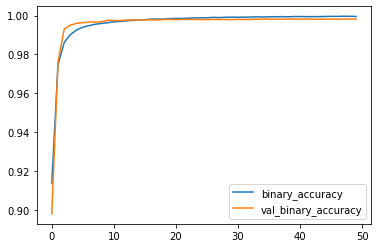

In [14]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

# **Predict TEST data**

In [37]:
predictions = model.predict(test_raw)

In [38]:
predictions[0]

array([2.5744887e-07, 1.8641341e-08, 9.9989879e-01, 2.4518415e-06,
       7.3077609e-07, 1.0014337e-07, 4.3488743e-08, 1.4280586e-06,
       3.3018176e-07, 2.3898011e-07], dtype=float32)

In [39]:
predictions=[np.argmax(test) for test in predictions]

In [40]:
predictions[0]

2

In [42]:
submission_raw = pd.read_csv("../input/digit-recognizer/sample_submission.csv")
submission_raw.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


# **Preparing outcome for submission**

In [45]:
final_submission = pd.DataFrame({'ImageId' : [i+1 for i in range(len(predictions))] , 'Label' : predictions})
final_submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [46]:
final_submission.to_csv('./final_submission.csv', index = False)